In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

In [ ]:


df = pd.read_csv('abcnews-date-text.csv')
df.head()


,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df['year'] = df['publish_date'].dt.year

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def process_batches(texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        yield torch.nn.functional.softmax(outputs.logits, dim=-1)

In [ ]:
all_sentiments = []
for batch_predictions in tqdm(process_batches(df['headline_text'].tolist()), total=len(df)//32 + 1):
    all_sentiments.extend(batch_predictions[:, 1].tolist())  # Positive sentiment scores

df['sentiment'] = all_sentiments

100%|██████████| 38881/38881 [09:42<00:00, 66.80it/s]


In [ ]:
sentiment_by_year = df.groupby('year').agg({
    'sentiment': 'sum',
    'headline_text': 'count'
}).rename(columns={'sentiment': 'positive_count', 'headline_text': 'total_count'})

sentiment_by_year['negative_count'] = sentiment_by_year['total_count'] - sentiment_by_year['positive_count']

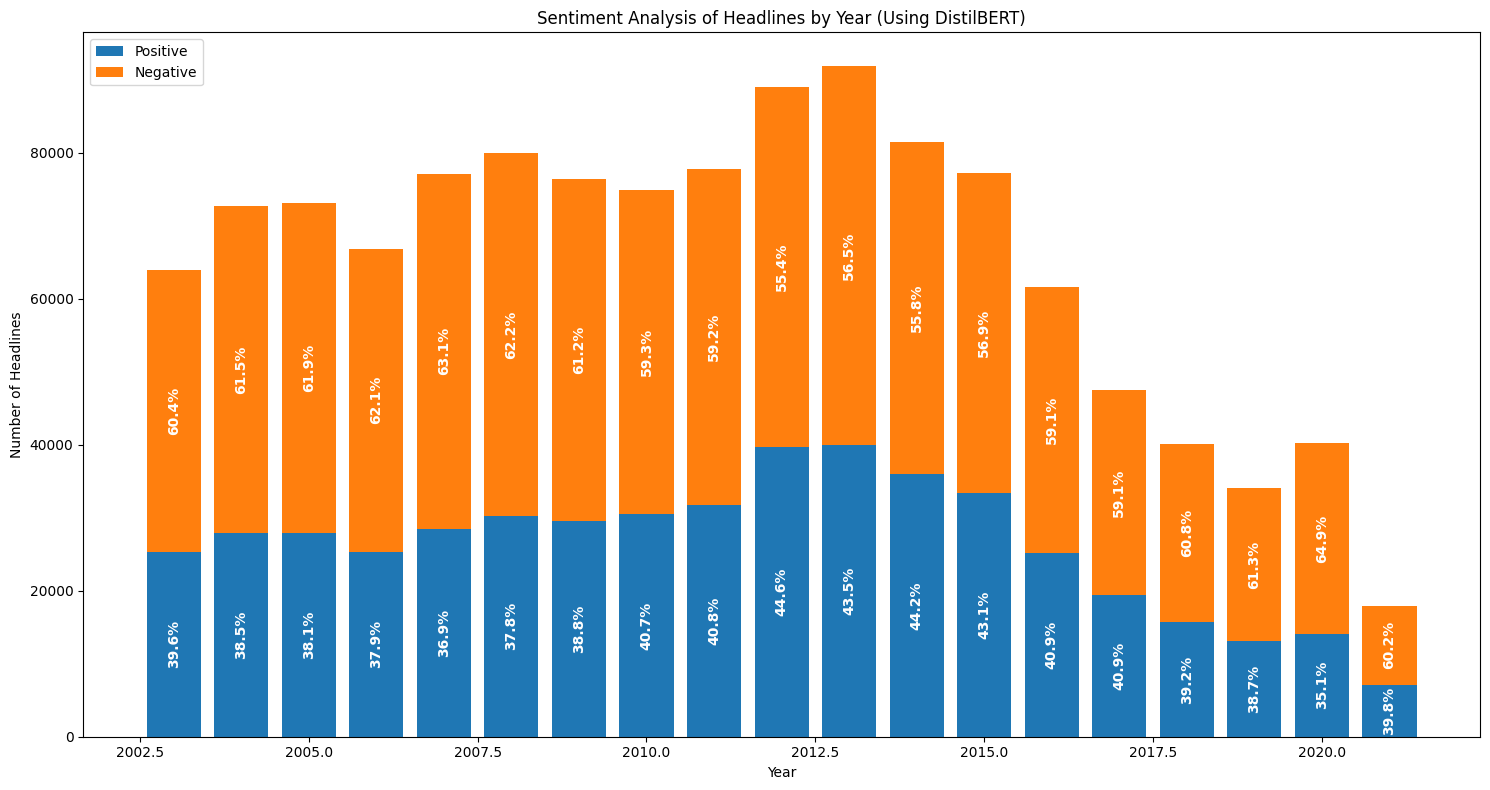

In [ ]:
plt.figure(figsize=(15, 8))

bars = plt.bar(sentiment_by_year.index, sentiment_by_year['positive_count'], label='Positive')
bars_neg = plt.bar(sentiment_by_year.index, sentiment_by_year['negative_count'],
                   bottom=sentiment_by_year['positive_count'], label='Negative')

plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Sentiment Analysis of Headlines by Year (Using DistilBERT)')
plt.legend(loc='upper left')

def add_percentages(bars, bars_neg):
    for i, (bar, bar_neg) in enumerate(zip(bars, bars_neg)):
        total = bar.get_height() + bar_neg.get_height()
        positive_percentage = (bar.get_height() / total) * 100
        negative_percentage = (bar_neg.get_height() / total) * 100

        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                 f'{positive_percentage:.1f}%',
                 ha='center', va='center', rotation=90, color='white', fontweight='bold')

        plt.text(bar_neg.get_x() + bar_neg.get_width()/2, bar.get_height() + bar_neg.get_height()/2,
                 f'{negative_percentage:.1f}%',
                 ha='center', va='center', rotation=90, color='white', fontweight='bold')

add_percentages(bars, bars_neg)

plt.tight_layout()
plt.show()